## Import libraries

In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
import spikeinterface.full as si
from probeinterface import read_probeinterface
from probeinterface.plotting import plot_probe

%matplotlib widget

Matplotlib created a temporary cache directory at /tmp/matplotlib-tx17bo75 because the default path (/home/jupyter-ikharitonov/.cache/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


In [2]:
print(f"SpikeInterface version: {si.__version__}")

SpikeInterface version: 0.99.0.dev0


## Define paths and configure default parameters

In [3]:
# Main working directory
base_folder = Path.home() / 'RANCZLAB-NAS' / 'iakov' / 'allen_sorting_07_11_23'

# Input data
binary_filename = 'spike_band.dat'

# Output sorting
output_folder = base_folder / 'kilosort3_sorting_files'
sorting_save_path = base_folder / 'kilosort3_sorting_output'

In [4]:
# Default parameters for compute-intensive steps
# n_jobs is the number of CPU cores used. -1 means use all cores.
job_kwargs = dict(n_jobs=-1, chunk_duration="1s", progress_bar=True)

# Plotting backend
backend = 'ipywidgets'

## Load data

In [5]:
# Recording parameters
sampling_frequency = 32000
dtype = np.int16
channel_number = 384

In [6]:
recordings = {}
recordings['raw'] = si.read_binary(base_folder / binary_filename, sampling_frequency=sampling_frequency, dtype=dtype, num_chan=channel_number)

/opt/tljh/user/envs/jh_si_env/lib/python3.10/site-packages/spikeinterface/core/binaryrecordingextractor.py:77: UserWarning: `num_chan` is to be deprecated in version 0.100, please use `num_channels` instead
  warnings.warn("`num_chan` is to be deprecated in version 0.100, please use `num_channels` instead")


FileNotFoundError: [Errno 2] No such file or directory: '/home/jupyter-ikharitonov/RANCZLAB-NAS/iakov/allen_sorting_07_11_23/spike_band.dat'

## Assign probe

(<matplotlib.collections.PolyCollection at 0x7f466345aa70>, None)

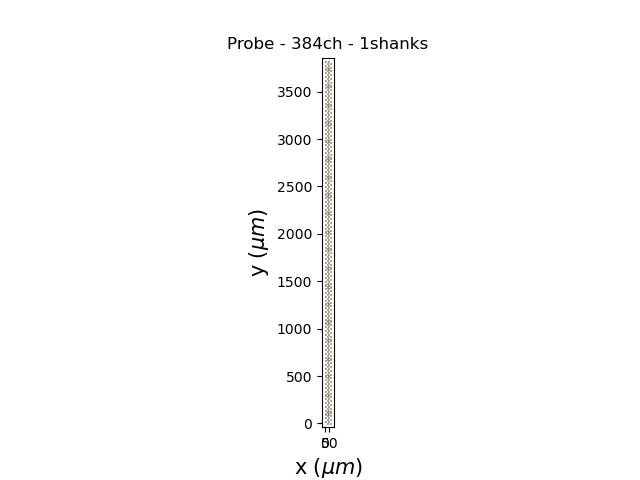

In [7]:
probegroup = read_probeinterface('np_json_files/np1.json')
probe = probegroup.probes[0]
recordings['raw'] = recordings['raw'].set_probe(probe)

plot_probe(probe)

## Apply preprocessing

### Bandpass filtering

In [8]:
recordings['bandpass'] = si.bandpass_filter(recordings['raw'], freq_min=300, freq_max=9000)

### Common median reference

In [9]:
recordings['common_median'] = si.common_reference(recordings['bandpass'], reference='global', operator='median')

## Plot data

In [10]:
si.plot_traces(recordings, mode='map', time_range=[0, 10], backend=backend)

AppLayout(children=(TimeSlider(children=(Dropdown(description='segment', options=(0,), value=0), Button(icon='…

## Save preprocessed recording

In [26]:
recordings['common_median'].save(folder=base_folder / "preprocessed_recording", **job_kwargs)

write_binary_recording with n_jobs = 36 and chunk_size = 32000


write_binary_recording:   0%|          | 0/8037 [00:00<?, ?it/s]


KeyboardInterrupt



## Send to sorting

### Define parameters

In [11]:
print(f"List of available spike sorters (in Singularity containers):\n{os.listdir(Path.home() / 'RANCZLAB-NAS' / 'spikesorter_images')}")

List of available spike sorters (in Singularity containers):
['kilosort-compiled-base.sif', 'kilosort3-compiled-base.sif', 'mountainsort5-base.sif', 'hdsort-compiled-base.sif', 'kilosort2-compiled-base.sif', 'ironclust-compiled-base.sif', 'kilosort2_5-compiled-base.sif']


In [14]:
sorter_name = 'kilosort2'
sorter_path = Path.home() / 'RANCZLAB-NAS' / 'spikesorter_images' / 'kilosort2-compiled-base.sif'

### Launch

In [15]:
sorting = si.run_sorter(sorter_name, recording=recordings['common_median'], output_folder=output_folder, singularity_image=sorter_path, verbose=True, **job_kwargs)
# sorting.save(folder=sorting_save_path, format='npz_folder', **job_kwargs)

Starting container
Installing spikeinterface from sources in /home/jupyter-ikharitonov/RANCZLAB-NAS/spikesorter_images/kilosort2-compiled-base.sif
Installing dev spikeinterface from remote repository


KeyboardInterrupt: 